In [2]:
import tensorflow as tf 
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras.applications.efficientnet import EfficientNetB1
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications.efficientnet import decode_predictions

from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Setup

In [98]:
model = EfficientNetB1(weights='imagenet', input_shape=(240,240, 3))

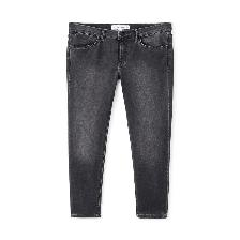

In [99]:
## Image encoding and array shape where RGB channels
image_path = './data/test/1000005435.jpg'
img = load_img(image_path, target_size=(240, 240))
x = np.array(img)
x.shape
img

In [100]:
X = np.array([x])

In [101]:
X = preprocess_input(X)

preds = model.predict(X)

1/1 [==============================] - 2s 2s/step


In [24]:
decode_predictions(preds)

[[('n03594734', 'jean', 0.82639027),
  ('n02910353', 'buckle', 0.008777495),
  ('n04525038', 'velvet', 0.0046414905),
  ('n04350905', 'suit', 0.0029998107),
  ('n04371430', 'swimming_trunks', 0.0029143316)]]

In [27]:
VALIDATION_SPLIT = 0.2
IMG_SIZE = 299
BATCH_SIZE = 32

In [258]:
# train_gen_augmented = ImageDataGenerator(
#     preprocessing_function= preprocess_input,
#     validation_split= VALIDATION_SPLIT,
# #     rotation_range=30,
# #     width_shift_range=10.0,
# #     height_shift_range=10.0,
#     shear_range=10.0,
#     zoom_range=0.1,
#     horizontal_flip=False,
#     vertical_flip=True
# )
# train_ds = train_gen_augmented.flow_from_directory(
#     './data/train',
#     subset="training",
#     target_size=(IMG_SIZE, IMG_SIZE),
#     batch_size=BATCH_SIZE
# )

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./data/train",
    validation_split= VALIDATION_SPLIT,
    subset="training",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    seed = 10
)

Found 4996 images belonging to 12 classes.


In [264]:
# val_gen = ImageDataGenerator(
#     preprocessing_function= preprocess_input,
#     validation_split= VALIDATION_SPLIT,
#     horizontal_flip=False,
#     vertical_flip=True
# )
# val_ds = val_gen.flow_from_directory(
#     './data/train',
#     subset="validation",
#     target_size=(IMG_SIZE, IMG_SIZE),
#     batch_size=BATCH_SIZE
# )


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./data/train",
    validation_split= VALIDATION_SPLIT,
    subset="validation",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    seed = 10
)

Found 6239 files belonging to 12 classes.
Using 1247 files for validation.


### Data transformation ( Augmentation )

In [265]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2, 0.2),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

# train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
# train_ds = augmented_train.map(preprocess_input)


In [266]:
color_classes = train.class_names
color_classes

['black',
 'blue',
 'brown',
 'green',
 'grey',
 'orange',
 'pink',
 'purple',
 'red',
 'silver',
 'white',
 'yellow']

### Dataset sample preview

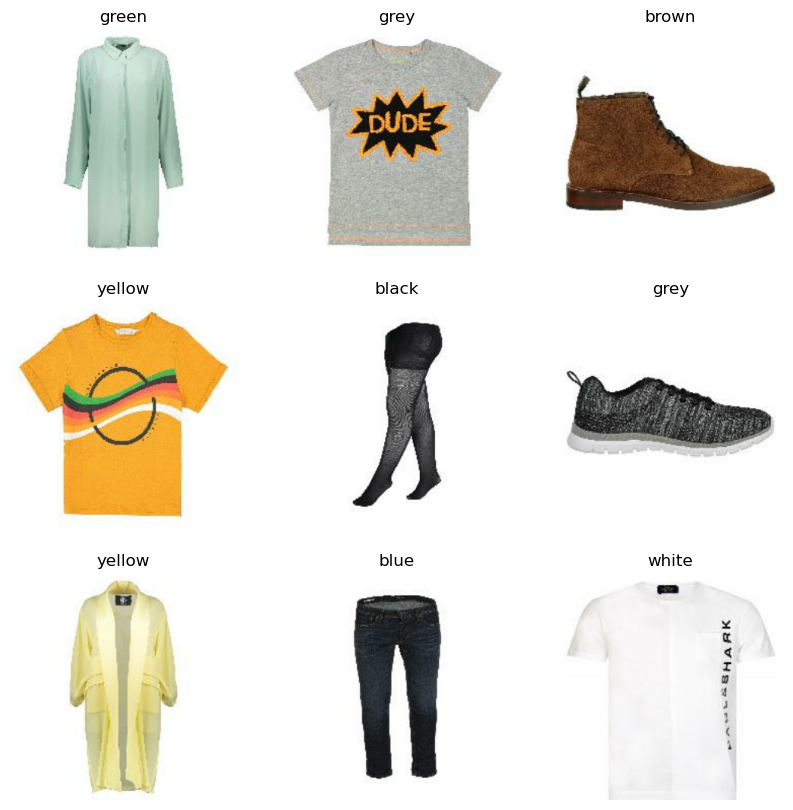

In [220]:
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(color_classes[np.argmax(labels[i])])
        plt.axis("off")

In [267]:
def create_model_instance(input_size= 150, learningRate = 0.01, inner_dense_size = 100, droprate = 0.2):
    base_model = EfficientNetB1(
        weights='imagenet',
        include_top=False,
        input_shape=(input_size, input_size,3)
    )
    base_model.trainable = False #ConvLayers will not change ( FREEZE )


    ## Create new top ( Dense layer that fit our dataset 
    inputs = keras.Input(shape=(input_size, input_size, 3))
    #batch 32 * 5 * 5 * 2048
    base = base_model(inputs, training = False)
    ## Shrink 3d Base into 1D vector
    pooling = keras.layers.GlobalAveragePooling2D()
    # 32 * 2048
    vectors = pooling(base)
    # Add extra dense layer with ReLU 32*100
    inner = keras.layers.Dense(inner_dense_size, activation = 'relu')(vectors)
    # How much of the network we freeze 32*100
    drop = keras.layers.Dropout(droprate)(inner)

    # 32 * 12 [ 12 color classes ]
    outputs = keras.layers.Dense(12)(drop) 
    model = keras.Model(inputs, outputs)


    ## To train the model, need an optimizer for weights
    optimizer = keras.optimizers.Adam(learning_rate=learningRate)
    # where optimizer make sure it's in the right direction
    loss = keras.losses.CategoricalCrossentropy(from_logits=True) 

    model.compile(optimizer, loss=loss, metrics=['accuracy'])

    return model

In [268]:
## Training parameters
EPOCHS = 50
LEARNING_RATE = 0.0005
DROP_RATE = 0.1
DENSE_LAYER_SIZE = 128

In [269]:
## Model callbacks on each epoch
checkpoint = keras.callbacks.ModelCheckpoint(
    'efficientnetb1_v1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only = True,
    monitor = 'val_accuracy',
    mode='max'
)

early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                           patience=8,
                           restore_best_weights=True,
                           mode='max')

callbacks = [early_stop]

### Model Training

In [271]:
model.save_weights('model_v1.h5', save_format='h5')
model = create_model_instance(
    input_size=IMG_SIZE, 
    learningRate = LEARNING_RATE,
    inner_dense_size = DENSE_LAYER_SIZE,
    droprate = 0.1)
history = model.fit(train_ds, epochs = EPOCHS, validation_data = val_ds, callbacks= callbacks)



Epoch 1/50
157/157 [==============================] - 99s 589ms/step - loss: 2.3960 - accuracy: 0.1485 - val_loss: 2.5526 - val_accuracy: 0.0882
Epoch 2/50
157/157 [==============================] - 91s 581ms/step - loss: 2.3286 - accuracy: 0.1747 - val_loss: 2.5663 - val_accuracy: 0.0786
Epoch 3/50
157/157 [==============================] - 91s 579ms/step - loss: 2.2936 - accuracy: 0.1886 - val_loss: 2.5879 - val_accuracy: 0.0850
Epoch 4/50
157/157 [==============================] - 91s 578ms/step - loss: 2.2806 - accuracy: 0.1918 - val_loss: 2.6160 - val_accuracy: 0.0794
Epoch 5/50
157/157 [==============================] - 88s 562ms/step - loss: 2.2700 - accuracy: 0.2000 - val_loss: 2.6504 - val_accuracy: 0.0810
Epoch 6/50
157/157 [==============================] - 90s 574ms/step - loss: 2.2536 - accuracy: 0.2062 - val_loss: 2.6913 - val_accuracy: 0.0810
Epoch 7/50
157/157 [==============================] - 91s 579ms/step - loss: 2.2461 - accuracy: 0.2012 - val_loss: 2.7337 - val_ac

KeyboardInterrupt: 

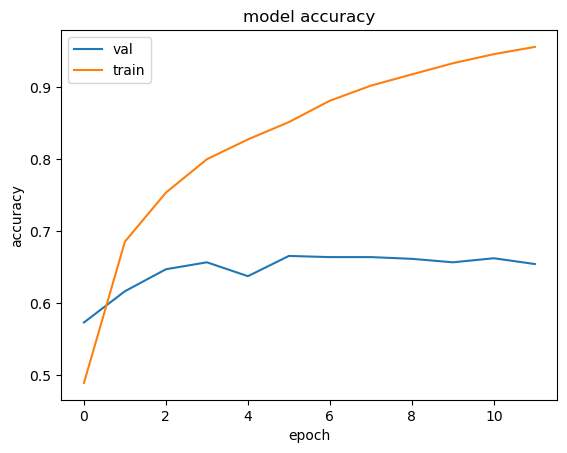

In [142]:
training_hist = history.history
plt.plot(training_hist['val_accuracy'], label='val')
plt.plot(training_hist['accuracy'], label='train')

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.legend()


### Tuning model hyperparameters

- Learning rate

In [205]:
scores = {}
# 0.0001, 0.001
for learning_rate in [0.005, 0.01, 0.05]:
    print(learning_rate)

    model = create_model_instance(
        input_size=IMG_SIZE, 
        learningRate = learning_rate,
        inner_dense_size = DENSE_LAYER_SIZE,
        droprate = DROP_RATE
    ) 
    history = model.fit(train_ds, epochs = EPOCHS, validation_data = val_ds, callbacks= callbacks)
    scores[learning_rate] = history.history

    print()
    print()

0.005
Epoch 1/50
156/156 [==============================] - 37s 195ms/step - loss: 1.4516 - accuracy: 0.5294 - val_loss: 1.1462 - val_accuracy: 0.6319
Epoch 2/50
156/156 [==============================] - 29s 183ms/step - loss: 0.9382 - accuracy: 0.7153 - val_loss: 1.0647 - val_accuracy: 0.6728
Epoch 3/50
156/156 [==============================] - 29s 182ms/step - loss: 0.7627 - accuracy: 0.7668 - val_loss: 1.0461 - val_accuracy: 0.6704
Epoch 4/50
156/156 [==============================] - 29s 182ms/step - loss: 0.6615 - accuracy: 0.7935 - val_loss: 1.0360 - val_accuracy: 0.6632
Epoch 5/50
156/156 [==============================] - 29s 184ms/step - loss: 0.5871 - accuracy: 0.8231 - val_loss: 1.0206 - val_accuracy: 0.6776
Epoch 6/50
156/156 [==============================] - 29s 183ms/step - loss: 0.5163 - accuracy: 0.8427 - val_loss: 1.0665 - val_accuracy: 0.6672
Epoch 7/50
156/156 [==============================] - 29s 183ms/step - loss: 0.4703 - accuracy: 0.8606 - val_loss: 1.0817 - 

156/156 [==============================] - 29s 183ms/step - loss: 0.9007 - accuracy: 0.8335 - val_loss: 4.9329 - val_accuracy: 0.6239
Epoch 11/50
156/156 [==============================] - 29s 184ms/step - loss: 0.7363 - accuracy: 0.8564 - val_loss: 4.8168 - val_accuracy: 0.6263
Epoch 12/50
156/156 [==============================] - 29s 183ms/step - loss: 0.7333 - accuracy: 0.8608 - val_loss: 5.0598 - val_accuracy: 0.6287
Epoch 13/50
156/156 [==============================] - 29s 184ms/step - loss: 0.6042 - accuracy: 0.8788 - val_loss: 4.9091 - val_accuracy: 0.6271
Epoch 14/50
156/156 [==============================] - 29s 183ms/step - loss: 0.6381 - accuracy: 0.8752 - val_loss: 5.4655 - val_accuracy: 0.6295
Epoch 15/50
156/156 [==============================] - 29s 183ms/step - loss: 0.6580 - accuracy: 0.8768 - val_loss: 5.8414 - val_accuracy: 0.6103
Epoch 16/50
156/156 [==============================] - 29s 184ms/step - loss: 0.6252 - accuracy: 0.8798 - val_loss: 6.0542 - val_accurac

- Select the best learning rate

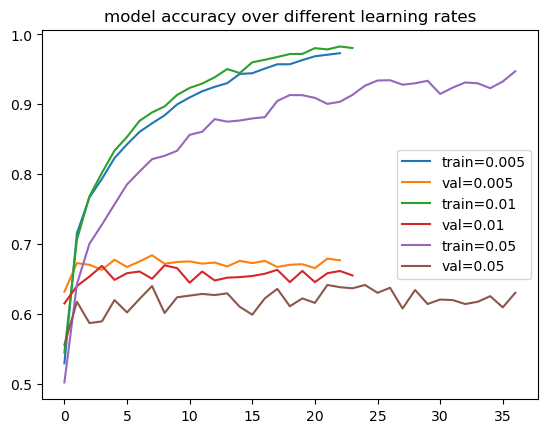

In [208]:
for learning_rate, history in scores.items():
    plt.plot(history['accuracy'], label = 'train=%s' % learning_rate)
    plt.plot(history['val_accuracy'], label = 'val=%s' % learning_rate)

# plt.xticks(np.arange(10))
plt.title('model accuracy over different learning rates')

plt.legend()

## the best learning rate = 0.001
# LEARNING_RATE = 

In [214]:
scores = {}

for size in [10, 100, 128, 256, 1000]:
    print(size)

    model = create_model_instance(
        input_size=IMG_SIZE, 
        learningRate = LEARNING_RATE,
        inner_dense_size = size,
        droprate = DROP_RATE
    ) 
    history = model.fit(train_ds, epochs = EPOCHS, validation_data = val_ds, callbacks= callbacks)
    scores[size] = history.history

    print()
    print()

256
Epoch 1/30
156/156 [==============================] - 37s 195ms/step - loss: 2.0396 - accuracy: 0.3486 - val_loss: 1.7507 - val_accuracy: 0.4675
Epoch 2/30
156/156 [==============================] - 29s 183ms/step - loss: 1.5946 - accuracy: 0.5272 - val_loss: 1.5193 - val_accuracy: 0.5389
Epoch 3/30
156/156 [==============================] - 29s 183ms/step - loss: 1.3890 - accuracy: 0.5891 - val_loss: 1.3851 - val_accuracy: 0.5814
Epoch 4/30
156/156 [==============================] - 29s 184ms/step - loss: 1.2568 - accuracy: 0.6314 - val_loss: 1.2991 - val_accuracy: 0.6103
Epoch 5/30
156/156 [==============================] - 29s 183ms/step - loss: 1.1631 - accuracy: 0.6581 - val_loss: 1.2379 - val_accuracy: 0.6279
Epoch 6/30
156/156 [==============================] - 29s 183ms/step - loss: 1.0902 - accuracy: 0.6793 - val_loss: 1.1904 - val_accuracy: 0.6383
Epoch 7/30
156/156 [==============================] - 29s 183ms/step - loss: 1.0312 - accuracy: 0.7009 - val_loss: 1.1549 - va

156/156 [==============================] - 29s 182ms/step - loss: 0.5828 - accuracy: 0.8421 - val_loss: 0.9719 - val_accuracy: 0.6872
Epoch 28/30
156/156 [==============================] - 29s 183ms/step - loss: 0.5722 - accuracy: 0.8448 - val_loss: 0.9708 - val_accuracy: 0.6856




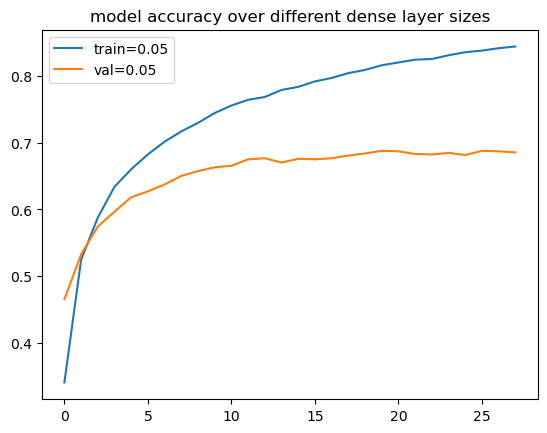

In [217]:
for size, history in scores.items():
    plt.plot(history['accuracy'], label = 'train=%s' % size)
    plt.plot(history['val_accuracy'], label = 'val=%s' % size)

# plt.xticks(np.arange(10))
plt.title('model accuracy over different dense layer sizes')

plt.legend()

## the best dense layer sizes = 0.001
DENSE_LAYER_SIZE = 100

In [ ]:
scores = {}

for droprate in [0.2, 0.5, 0.8]:
    print(droprate)

    model = create_model_instance(
        input_size=IMG_SIZE, 
        learningRate = LEARNING_RATE,
        inner_dense_size = DENSE_LAYER_SIZE,
        droprate = droprate
    ) 
    history = model.fit(train_ds, epochs = EPOCHS, validation_data = val_ds, callbacks= callbacks)
    scores[learning_rate] = history.history

    print()
    print()

In [ ]:
for droprate, history in scores.items():
    plt.plot(history['accuracy'], label = 'train=%s' % droprate)
    plt.plot(history['val_accuracy'], label = 'val=%s' % droprate)

plt.xticks(np.arange(10))
plt.title('model accuracy over different dropout values')

plt.legend()

## the best dropout value = 0.001
DROP_RATE = 

# Training with `EfficientNetB3` Model

In [247]:
from tensorflow.keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions

In [248]:
train_gen_augmented = ImageDataGenerator(
    preprocessing_function= preprocess_input,
    validation_split= VALIDATION_SPLIT,
#     shear_range=10.0,
#     zoom_range=0.1,
    horizontal_flip=False,
#     vertical_flip=True
)
train_ds = train_gen_augmented.flow_from_directory(
    './data/train',
    subset="training",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)


val_gen = ImageDataGenerator(
    preprocessing_function= preprocess_input,
    validation_split= VALIDATION_SPLIT,
    horizontal_flip=False,
    vertical_flip=True
)
val_ds = val_gen.flow_from_directory(
    './data/train',
    subset="validation",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

Found 4996 images belonging to 12 classes.
Found 1243 images belonging to 12 classes.


In [251]:
## Training parameters
EPOCHS = 30
LEARNING_RATE = 0.001
DROP_RATE = 0.2
DENSE_LAYER_SIZE = 100

In [252]:
def create_model_InceptionV3(input_size= 150, learningRate = 0.01, inner_dense_size = 100, droprate = 0.2):
    base_model = EfficientNetB3(
        weights='imagenet',
        include_top=False,
        input_shape=(input_size, input_size,3)
    )
    base_model.trainable = False #ConvLayers will not change ( FREEZE )


    ## Create new top ( Dense layer that fit our dataset 
    inputs = keras.Input(shape=(input_size, input_size, 3))
    #batch 32 * 5 * 5 * 2048
    base = base_model(inputs, training = False)
    ## Shrink 3d Base into 1D vector
    pooling = keras.layers.GlobalAveragePooling2D()
    # 32 * 2048
    vectors = pooling(base)
    # Add extra dense layer with ReLU 32*inner_dense_size
    inner = keras.layers.Dense(inner_dense_size, activation = 'relu', name="dense_1")(vectors)
#     inner2 = layers.Dense(inner_dense_size, activation="relu", name="dense_2")(inner)

    # How much of the network we freeze 32*100
    drop = keras.layers.Dropout(droprate)(inner)

    # 32 * 12 [ 12 color classes ]
    outputs = keras.layers.Dense(12, activation="softmax", name="predictions")(drop) 
    model = keras.Model(inputs, outputs)


    ## To train the model, need an optimizer for weights
    optimizer = keras.optimizers.Adam(learning_rate=learningRate)
    # where optimizer make sure it's in the right direction
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True) 

    model.compile(optimizer, loss=loss, metrics=['sparse_categorical_accuracy'])

    return model

### Tuning model hyperparameters

In [253]:
scores = {}

for learning_rate in [0.001, 0.005, 0.01, 0.05]:
    print(learning_rate)

    model = create_model_instance(
        input_size=IMG_SIZE, 
        learningRate = learning_rate,
        inner_dense_size = DENSE_LAYER_SIZE,
        droprate = DROP_RATE
    ) 
    history = model.fit(train_ds, epochs = EPOCHS, validation_data = val_ds, callbacks= callbacks)
    scores[learning_rate] = history.history

    print()
    print()

0.001
Epoch 1/30
157/157 [==============================] - 36s 188ms/step - loss: 2.4162 - accuracy: 0.1389 - val_loss: 2.3371 - val_accuracy: 0.1794
Epoch 2/30
157/157 [==============================] - 27s 174ms/step - loss: 2.3354 - accuracy: 0.1755 - val_loss: 2.3071 - val_accuracy: 0.1778
Epoch 3/30
157/157 [==============================] - 28s 176ms/step - loss: 2.3093 - accuracy: 0.1745 - val_loss: 2.2905 - val_accuracy: 0.2132
Epoch 4/30
157/157 [==============================] - 27s 175ms/step - loss: 2.2939 - accuracy: 0.1807 - val_loss: 2.2835 - val_accuracy: 0.1931
Epoch 5/30
157/157 [==============================] - 27s 174ms/step - loss: 2.2757 - accuracy: 0.1954 - val_loss: 2.2769 - val_accuracy: 0.1850
Epoch 6/30
157/157 [==============================] - 28s 176ms/step - loss: 2.2697 - accuracy: 0.1920 - val_loss: 2.2544 - val_accuracy: 0.2180
Epoch 7/30
157/157 [==============================] - 28s 175ms/step - loss: 2.2516 - accuracy: 0.1996 - val_loss: 2.2566 - 

KeyboardInterrupt: 